In [ ]:
from __future__ import absolute_import

import cv2
import numpy as np
import os
import os.path as osp
import pdb
from matplotlib import pyplot as plt

def unit16b2uint8(img):
    if img.dtype == 'uint8':
        return img
    elif img.dtype == 'uint16':
        return img.astype(np.uint8)
    else:
        #raise TypeError('No such of img transfer type: {} for img'.format(img.dtype))
        return img.astype(np.uint8)

def img_standardization(img):
    img = unit16b2uint8(img)
    if len(img.shape) == 2:
        img = np.expand_dims(img, 2)
        img = np.tile(img, (1, 1, 3))
        return img
    elif len(img.shape) == 3:
        return img
    else:
        raise TypeError('The Depth of image large than 3 \n')
    
def load_images(file_names):
    images = []
    try:
        for file_name in file_names:
            #pdb.set_trace()
            img = cv2.imread(file_name, -1)
            img = img_standardization(img)
            images.append(img)
    except MemoryError: 
        print(file_name)
        pdb.set_trace()
    return images

def new_load_images(file_names):
    images = []
    try:
        for file_name in file_names:
            img = cv2.imread(file_name, -1)
            img = img_standardization(img)
            img = bgr_to_gray(img)
            img = img.astype('float32')
            images.append(img / 255)
    except MemoryError: 
        print(file_name)
        pdb.set_trace()
    return images

def bgr_to_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img 


class BinaryThresholding:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, img):
        gray = bgr_to_gray(img)
        (_, binary_mask) = cv2.threshold(gray, self.threshold, 255, cv2.THRESH_BINARY)
        binary_mask = cv2.medianBlur(binary_mask, 5)
        connectivity = 4
        _, label_img, _, _ = cv2.connectedComponentsWithStats(binary_mask , connectivity , cv2.CV_32S)
        return label_img
    

def origin_main():
    segmentor = BinaryThresholding(threshold=110)
    x_train_path = './dataset1/train/'
    y_train_path = './dataset1/train_GT/SEG/'
    test_path = './dataset1/test/'
    result_path = './dataset1/test_RESRES'
    if not osp.exists(result_path):
        os.mkdir(result_path)
    x_train_list = sorted([osp.join(x_train_path, x) for x in os.listdir(x_train_path) if x.find('.tif') != -1])
    y_train_list = sorted([osp.join(y_train_path, y) for y in os.listdir(y_train_path) if y.find('.tif') != -1])
    test_list = sorted([osp.join(test_path, test) for test in os.listdir(test_path) if test.find('.tif') != -1])
    X_train = load_images(x_train_list)
    Y_train = load_images(y_train_list)
    images = load_images(test_list)
    for index, image in enumerate(images):
        label_img = segmentor(image)
        cv2.imwrite(osp.join(result_path, 'mask{:0>3d}.tif'.format(index)), label_img.astype(np.uint16))
        
    print("done")
    print(len(X_train), len(Y_train), len(images))
    plt.imshow(X_train[0])
    plt.show
    return

    
origin_main()

In [2]:
import numpy as np 
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend

In [3]:
#backend.set_image_data_format('channels_first')
def iou(y_pred, y_true):
    return tf.metrics.mean_iou(y_true, y_pred)

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = keras.Input(shape = input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
    
    model.summary()


    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [4]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold


In [5]:

"""X = np.array(X_train)
Y = np.array(Y_train)
X = X.reshape(175*628*628,3)
Y = Y[:,:,:,0].reshape(-1,1)"""
'''
print(X.shape)
print(Y.shape)
print(X)
print(Y)
print(X_train)
print(Y_train)
'''

'\nprint(X.shape)\nprint(Y.shape)\nprint(X)\nprint(Y)\nprint(X_train)\nprint(Y_train)\n'

In [6]:
"""def useKMeans():
    #img = cv2.imread('./dataset1/test/t000.tif',-1)
    for i in range(33):
        img = images[i]
        #print(np.array(img).shape)
        #print(np.array(images).shape)
        b, g, r = cv2.split(img)
        img = cv2.merge([r,g,b])
        img_flat = np.array(img).reshape((img.shape[0] * img.shape[1], 3))
        img_flat = np.float32(img_flat)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_MAX_ITER, 20, 0.5)
        flags = cv2.KMEANS_RANDOM_CENTERS
        K = 2
        compactness, labels, centers = cv2.kmeans(img_flat, K, None, criteria, 10, flags)
        
        img_output = labels.reshape((img.shape[0], img.shape[1]))
        plt.imshow(img_output)
        plt.show
        cv2.imwrite(osp.join('./dataset1/res1', 'mask{:0>3d}.tif'.format(i)), img_output.astype(np.uint16))
        """
def makezip():
    import zipfile
    source = './dataset1/res1'
    target_name = './dataset1/dataset1.zip'
    fzip = zipfile.ZipFile(target_name, 'w', zipfile.ZIP_DEFLATED)
    flist = os.listdir(source)
    #basename = os.path.basename(source)
    for name in flist:
        fpath = os.path.join(source, name)
        #arcname = os.path.join(basename, name)
        #写入要压缩文件，并添加归档文件名称
        fzip.write(fpath)
    #关闭
    fzip.close()


In [7]:
#useKMeans()
#makezip()

In [8]:
model = unet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
 
        for i in range(num_class):
            new_mask[mask == i,i] = 1 #将平面的mask的每类，都单独变成一层，
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = unit16b2uint8(img)
        mask = unit16b2uint8(mask)
        img = img / 255
        mask = mask / 255
        mask[mask > 0] = 1
        mask[mask <= 0] = 0
    return (img,mask)

def train_Generator(batch_size,train_path, mask_path, image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False, num_class = 2,save_to_dir = None,save_path = None, target_size = (256, 256),seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
   
        
def testGenerator(test_path,target_size = (256,256),flag_multi_class = False,as_gray = True):
    files = os.listdir(test_path)
    for file in files:
        img = cv2.imread(os.path.join(test_path,file),-1)
        img = img / 255
        img = cv2.resize(img,target_size)
        img = np.reshape(img,img.shape + (1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,) + img.shape)
        yield img


In [ ]:
aug_path = './dataset1/aug2'
if not osp.exists(aug_path):
    os.mkdir(aug_path)
    
res1_path = './dataset1/res1'
if not osp.exists(res1_path):
    os.mkdir(res1_path)
    
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='nearest')
myGene = train_Generator(2,'./dataset1','./dataset1/train_GT','train','SEG',data_gen_args,save_path = aug_path)
print(next(myGene)[0].shape)
print(next(myGene)[1].shape)
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=2,callbacks=[model_checkpoint])
#model.fit(X_train, Y_train, batch_size = 32,epochs=1,callbacks=[model_checkpoint])

Found 175 images belonging to 1 classes.
Found 175 images belonging to 1 classes.
(2, 256, 256, 1)
(2, 256, 256, 1)
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 300 steps
Epoch 1/2
 85/300 [=======>......................] - ETA: 34s - loss: 0.1437 - accuracy: 0.8866 - mean_io_u: 0.4433

In [ ]:
testGene = testGenerator(r"./dataset1/test")

results = model.predict_generator(testGene,33,verbose=1)

print(results.shape)
for i in range(33):
    result = results[i]
    #result = result
    result = cv2.resize(result, (628,628))
    result = img_standardization(result)
    #result = unit16b2uint8(result)
    print(result.shape)
    
    
plt.imshow(result)
plt.show
cv2.imshow('Example',result)
cv2.waitKey(0)

33/33 [==============================] - 1s 20ms/step
(33, 256, 256, 1)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)
(628, 628, 3)


In [15]:
image_path = './dataset1/test/'
image_list = sorted([osp.join(image_path, image) for image in os.listdir(image_path)])
n_images = new_load_images(image_list)
N = len(n_images)
n_images = np.array(n_images)
n_images = n_images.reshape(N, 628, 628, 1)
test = np.empty((N, 256, 256))
shape = (256, 256)
for i in range(N):
    test[i] = cv2.resize(n_images[i], shape)
plt.imshow(test[0])
plt.show()
print(N)
test = test.reshape(N, 256, 256, 1)
results = model.predict_generator(test,11,verbose=1)
for index,item in enumerate(results):
    cv2.imwrite(osp.join(res1_path, 'mask{:0>3d}.tif'.format(index)), label_img.astype(np.uint16))


33/33 [==============================] - 11s 347ms/sample


NameError: name 'result' is not defined

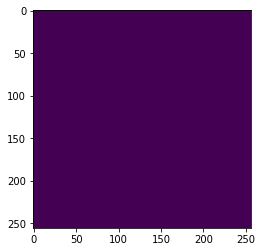

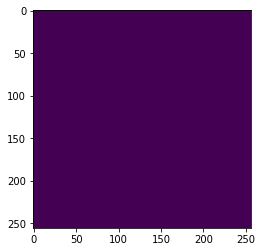

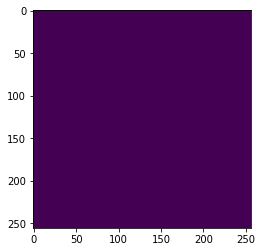

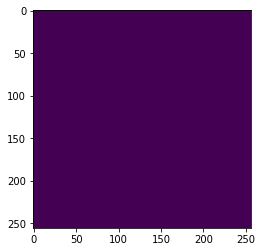

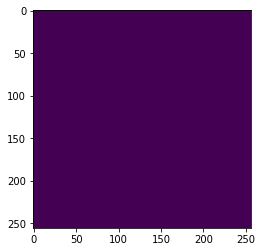

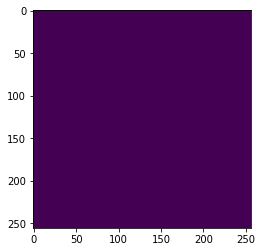

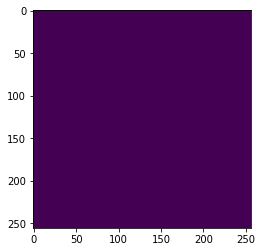

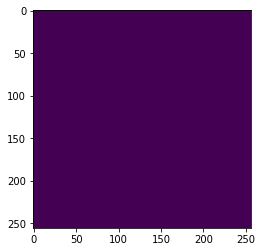

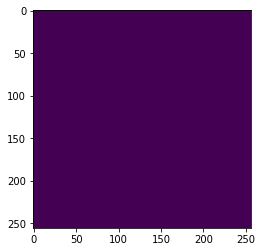

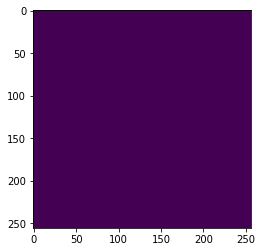

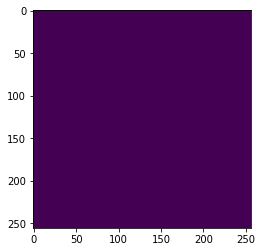

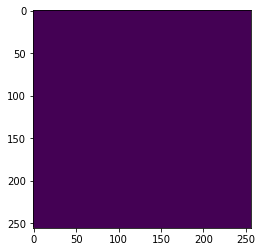

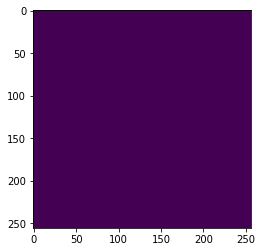

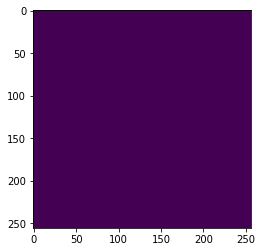

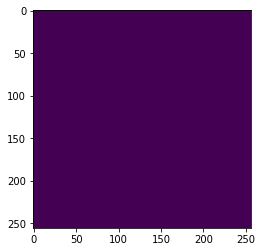

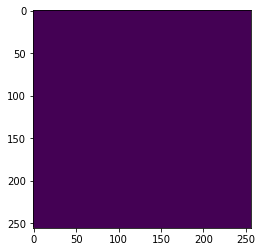

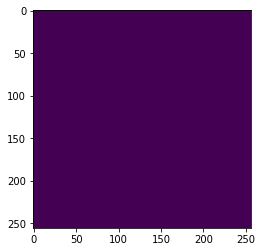

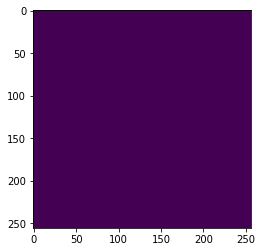

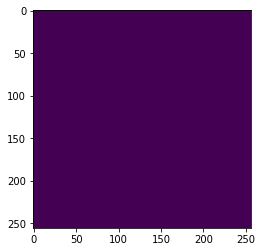

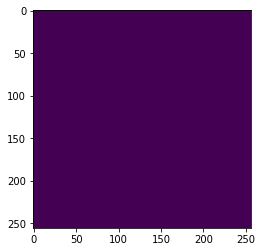

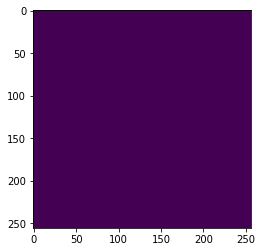

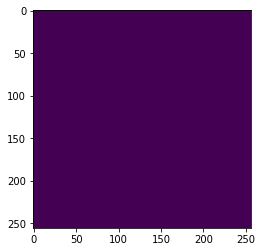

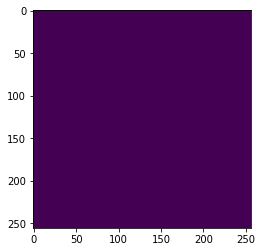

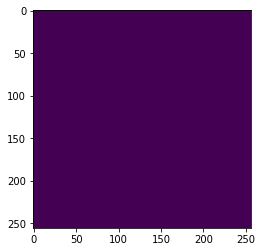

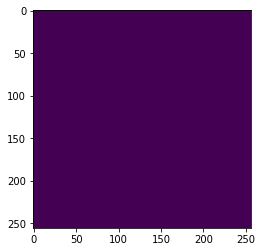

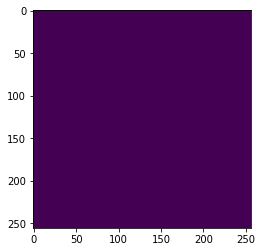

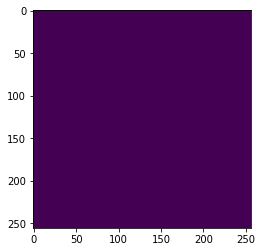

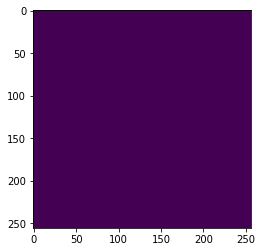

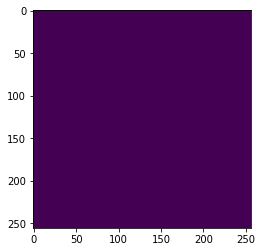

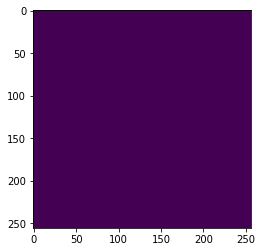

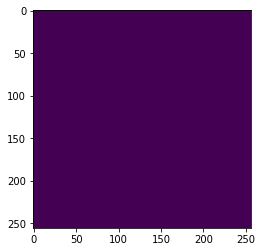

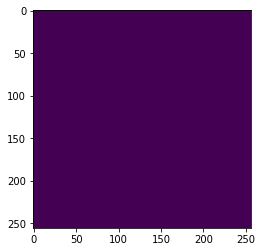

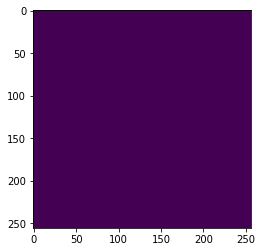

In [17]:
for i in range(33):
    r0 = results[i].reshape(256,256)
    plt.imshow(r0)
    plt.show()


In [24]:
import zipfile
source = './dataset1/res1'
target_name = './dataset1/dataset1.zip'
fzip = zipfile.ZipFile(target_name, 'w', zipfile.ZIP_DEFLATED)
flist = os.listdir(source)
#basename = os.path.basename(source)
for name in flist:
    fpath = os.path.join(source, name)
    #arcname = os.path.join(basename, name)
    #写入要压缩文件，并添加归档文件名称
    fzip.write(fpath)
#关闭
fzip.close()


In [20]:
if os.system(zip_command) == 0:
    print ('Successful backup to', target)
else:
    print ('Backup FAILED \
    !!!use sudo in the terminal')

Backup FAILED     !!!use sudo in the terminal
